# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt


Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='assets/mnist.png'>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Compose: Composes several transforms together
# torchvision.transforms.Normalize(mean, std):
# input[channel] = (input[channel] - mean[channel]) / std[channel]

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Processing...
Done!


In [11]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /Users/yifanguo/.pytorch/MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

class torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)

Parameters:	

    root (string) – Root directory of dataset where processed/training.pt and processed/test.pt exist.
    
    train (bool, optional) – If True, creates dataset from training.pt, otherwise from test.pt.
    
    download (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
    
    transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop
    
    target_transform (callable, optional) – A function/transform that takes in the target and transforms it.

class torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)

__Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.__

Parameters:	
  * dataset (Dataset) – dataset from which to load the data.
  * batch_size (int, optional) – how many samples per batch to load (default: 1).
  * shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
  * sampler (Sampler, optional) – defines the strategy to draw samples from the dataset. If specified, shuffle must be False.
  * batch_sampler (Sampler, optional) – like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
  * num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
  * collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
  * pin_memory (bool, optional) – If True, the data loader will copy tensors into CUDA pinned memory before returning them.
  * drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
  * timeout (numeric, optional) – if positive, the timeout value for collecting a batch from workers. Should always be non-negative. (default: 0)
  * worker_init_fn (callable, optional) – If not None, this will be called on each worker subprocess with the worker id (an int in [0, num_workers - 1]) as input, after seeding and before data loading. (default: None)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [21]:
dataiter.sample_iter

<generator object BatchSampler.__iter__ at 0x10ef629e8>

This is what one of the images looks like. 

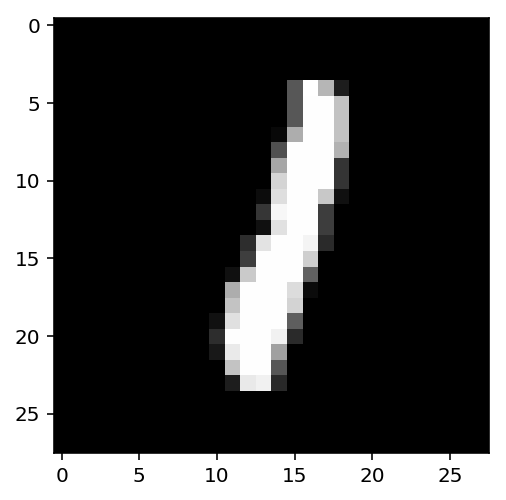

In [14]:
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

numpy.squeeze(a, axis=None)[source]

__Remove single-dimensional entries from the shape of an array.__

e.g.,

> images[0].numpy().shape

> (1, 28, 28)

After squeezing,

> images[0].numpy().squeeze().shape

> (28, 28)

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 1, 28, 28)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

Previously you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [52]:
## Your solution
torch.manual_seed(7)

# activation function
def activation(x):
    return 1. / (1 + torch.exp(-x))

# Flatten # hint point: Flatten -> images.view(images.shape[0], -1)
images = images.view(images.shape[0], -1)
print(images.shape)

# define the number of units per layer
batches = images.shape[0]
input_unit = images.shape[1]
hidden_unit = 256
output_unit = 10

# define the weight and bias
W1 = torch.rand([input_unit, hidden_unit])
b1 = torch.rand([1, hidden_unit])

W2 = torch.rand([hidden_unit, output_unit])
b2 = torch.rand([1, output_unit])

# Combination 
out = torch.mm(activation(torch.mm(images, W1) + b1), W2) + b2# output of your network, should have shape (64,10)
print(out.shape)
print(out[0])

torch.Size([64, 784])
torch.Size([64, 10])
tensor([ 0.6130,  0.8893,  0.2481,  0.2417,  0.2499,  0.7192,  0.8453,
         0.4047,  0.3531,  0.0244])


__broadcasting__

> a = torch.rand([3,2])

> a

> tensor([[ 0.2957,  0.0588],
>        [ 0.3062,  0.1345],
>        [ 0.3238,  0.7543]])

> b = torch.rand([1,2])

> b

> tensor([[ 0.0055,  0.8495]])

> a + b

> tensor([[ 0.3012,  0.9083],
>        [ 0.3116,  0.9840],
>        [ 0.3293,  1.6038]])

Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. Something that looks like this:
<img src='assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way PyTorch will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `dim` keyword in `torch.sum`. Setting `dim=0` takes the sum across the rows while `dim=1` takes the sum across the columns.

In [59]:
batches = 64

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim = 1).view(batches, 1)
    ## TODO: Implement the softmax function here

# Here, out should be the output of the network in the previous excercise with shape (64,10)
probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))
# display the output of images - the probability's distribution
print(probabilities[0])

torch.Size([64, 10])
tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000])
tensor([ 0.1122,  0.1480,  0.0779,  0.0774,  0.0781,  0.1248,  0.1416,
         0.0911,  0.0866,  0.0623])


## Building networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [60]:
from torch import nn

In [61]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation a reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [62]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [63]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

### Activation functions

So far we've only been looking at the softmax activation, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

### Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

In [73]:
## Your solution here
import torch.nn.functional as F

class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64,10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.output(x), dim = 1)
        return x

model = MyNetwork()
model

MyNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [68]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor(1.00000e-02 *
       [[ 0.7423,  1.2612,  1.3649,  ..., -3.0545,  0.3137, -1.6912],
        [-0.5561, -3.1342,  2.5013,  ..., -2.7626, -0.3457, -0.1126],
        [-0.5915, -2.8370, -0.9211,  ...,  1.4586,  0.9180, -3.4712],
        ...,
        [-2.2670,  3.1320, -2.6547,  ..., -2.8014,  2.6764, -0.7444],
        [-2.0310,  0.4836,  2.1801,  ..., -2.8261,  2.3582, -2.0928],
        [-0.3743,  1.3756, -2.7354,  ...,  2.6787, -3.3771, -2.6043]])
Parameter containing:
tensor(1.00000e-02 *
       [-2.8512, -1.1059, -3.2102, -2.4496,  2.1074, -2.4646,  0.0136,
        -3.4056, -2.5767, -1.9709, -1.5721,  0.3120, -3.4082, -3.3588,
        -1.3863,  0.0389,  2.3295,  2.2416, -2.0000,  3.2312,  0.9649,
        -0.5396, -0.0291, -2.9708,  3.1073,  0.0995,  0.8816, -1.5771,
         2.0544,  1.5763,  3.1504,  0.8461, -2.4260, -1.3151, -2.3938,
         0.5793,  0.2616,  0.7961,  2.6041, -1.9122, -3.5581,  0.3369,
        -3.3528,  2.3323,  2.7915, -0.6992, -0.7437,  

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [70]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [71]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 1.2599e-02,  8.5621e-03,  7.5199e-04,  ...,  1.7835e-02,
          1.5999e-02,  2.4832e-03],
        [-3.5209e-03,  1.6388e-04, -4.7203e-03,  ..., -5.6282e-03,
         -1.4010e-02,  2.3912e-03],
        [-1.1154e-02,  1.7732e-02, -1.6371e-03,  ..., -3.7278e-03,
          1.3431e-02, -8.2038e-03],
        ...,
        [ 4.7401e-03,  9.0215e-04, -1.0332e-02,  ...,  5.6793e-03,
          1.2280e-02, -8.9273e-03],
        [ 1.3787e-02, -4.7014e-03, -2.1116e-02,  ...,  1.6893e-02,
          2.5877e-02,  1.1206e-02],
        [ 4.8886e-04,  1.0193e-02,  1.1000e-02,  ...,  1.3222e-03,
         -1.2775e-02, -5.7862e-03]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

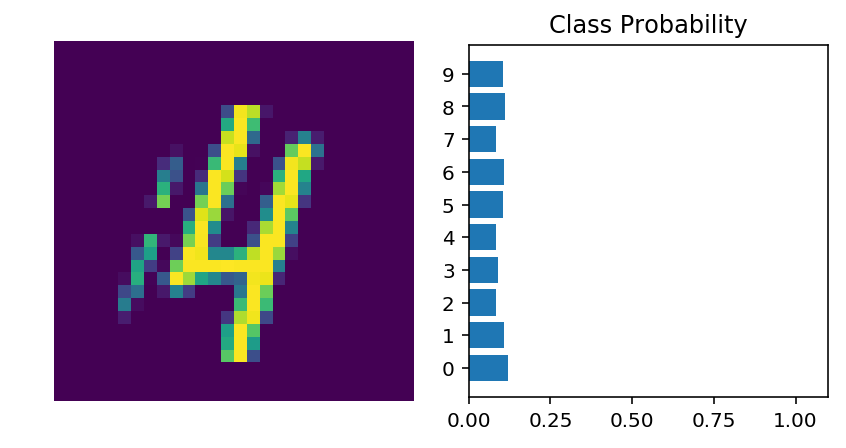

In [74]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps) # good feature!

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


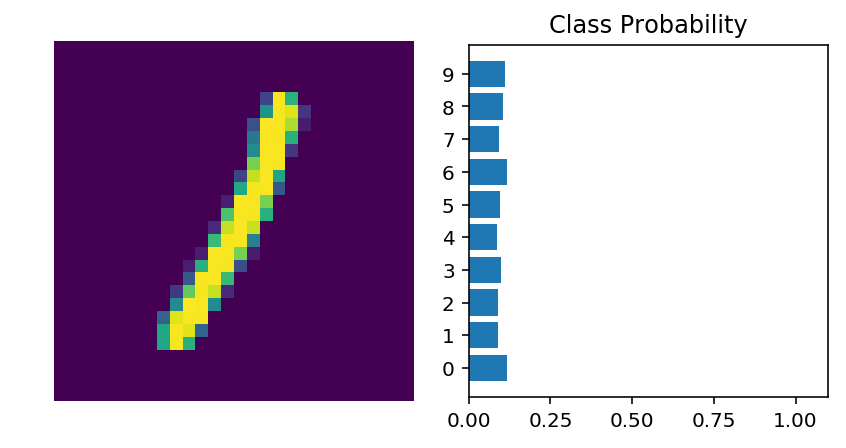

In [75]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Here our model is the same as before: 784 input units, a hidden layer with 128 units, ReLU activation, 64 unit hidden layer, another ReLU, then the output layer with 10 units, and the softmax output.

The operations are availble by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use `model[0]`.

In [76]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-2.8616e-02,  1.6762e-02,  1.6585e-03,  ...,  4.2443e-03,
          3.0570e-02, -1.8795e-03],
        [-1.0901e-02,  1.6314e-02,  7.0567e-04,  ...,  2.0690e-02,
         -2.8057e-02, -1.9197e-02],
        [ 1.2428e-02, -2.3625e-03,  2.1095e-02,  ..., -7.2633e-03,
         -2.6993e-02, -8.2412e-03],
        ...,
        [ 1.8873e-02, -4.9611e-03,  9.0888e-03,  ...,  2.6348e-02,
         -9.7045e-03, -3.5680e-02],
        [ 2.3646e-02, -3.4130e-02,  2.3088e-02,  ...,  6.2291e-03,
          3.5258e-02,  2.7057e-02],
        [-2.3246e-02, -3.3923e-02,  1.5292e-02,  ...,  2.7207e-02,
          1.5515e-02,  3.5303e-02]])

You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [77]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now you can access layers either by integer or the name

In [78]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In the next notebook, we'll see how we can train a neural network to accuractly predict the numbers appearing in the MNIST images.